In [1]:
import multiprocessing
from functools import reduce
import operator
import random
import h5py

import numpy as np
import scipy as sp
from scipy import signal
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from neuron import h

%load_ext autoreload
%autoreload 2

from GrC import GrC
from Golgi import Golgi
from utils import export_data

# np.random.seed(42)

--No graphics will be displayed.


In [2]:
# Instantiation of the cell templates

golgi_cells = [[Golgi(i, morpho) for i in range(count)] for morpho, count in (
    (1, 1),  # morpho 1
    (2, 1),  # morpho 2
 )]

golgi_cells = reduce(operator.concat, golgi_cells)

grc_cells = [[GrC(i, subtype) for i in range(count)] for subtype, count in (
    ("regular", 1), # 20%
    ("mild", 1), # 30%
    ("adapting", 1), # 40%
    ("accelerate", 1), # 10%
)]

grc_cells = reduce(operator.concat, grc_cells)

ascending_axons = sum((grc_cell.HD_aa for grc_cell in grc_cells), [])
parallel_fibers = sum((grc_cell.HD_pf for grc_cell in grc_cells), [])



5394 lines read

5456 lines read

morphology/pair-140514-C2-1_split_2.asc problems


Main branch starting at line 58 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

Main branch starting at line 2375 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

103 lines read

103 lines read

103 lines read

103 lines read


In [3]:
# Fixed time step only
time_step = h.CVode()
time_step.active(0)  # 0 fixed step, 1 variable time step

DO_IMPEDANCE_MEASUREMENT = False

if DO_IMPEDANCE_MEASUREMENT:
    h.load_file("stdrun.hoc")
else:
    # Activate the multisplit to use half of cores available (with a max of 8)
    cpu = multiprocessing.cpu_count() // 2
    h.load_file("parcom.hoc")
    p = h.ParallelComputeTool()
    p.change_nthread(min(8, cpu), 1)
    p.multisplit(1)

In [4]:
# simulation parameters
 
h.dt = 0.025    # change in time between steps (ms)
h.celsius = 32  # temperature of the neurons (*C)
h.v_init = -65  # initial membrane potential (mV)
h.tstop = 1500 # duration of simulation (ms)

# stim parameters
delay = 250 # when current injection starts
duration = 1000 # duration
freq = 100 # Hz

# release probability
lower = 0.25 # lower bounds
upper = 0.75 # upper bounds
mu = 0.5 # mean
sigma = 0.1 # standard deviation
N = 7 # amount of numbers needed
syn_weight = sp.stats.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)
print(syn_weight)

golgi_vm = [] # list for golgi voltage vector
grc_vm = [] # list for grc voltage vector

golgi_halfwidth_array = [] # list for golgi halfwidth
grc_halfwidth_array = [] # list for grc halfwidth

golgi_ncs_array = [] # list for golgi netcons
grc_ncs_array = [] # list for grc netcons

golgi_fr_array = [] # list for # of times a golgi cell spiked to determine firing rate
grc_fr_array = [] # list for # of times a grc cell spiked to determine firing rate

max_golgi_v_array = [] # list for golgi cell max voltage
min_golgi_v_array = [] # list for golgi cell min voltage
max_grc_v_array = [] # list for grc cell max voltage
min_grc_v_array = [] # list for grc cell min voltage

# dict of stim data to be sent for mf stims
stim_data = {'delay': delay, 'duration': duration, 'freq': freq}

# time vectors
t = h.Vector()
t.record(h._ref_t)

[0.50669859 0.46014484 0.53716267 0.60557958 0.59670784 0.41348885
 0.4829672 ]


Vector[28589]

In [5]:
for j, grc_cell in enumerate(grc_cells):
    
    # number of AMPA syn, NMDA syn, GABA syn, dend number from indices
    # grc cells connect to 4 different glomeri and synapse
    grc_cell.createsyn(4, 4, 3, [0, 1, 2, 3]) # 4 dendritic comparts (0-3)
    
    # golgi cell connection 
    for i, golgi_cell in enumerate(golgi_cells):
        grc = grc_cell.dend[:]
        sections = [grc[random.randrange(len(grc))] for _ in grc] 
        grc_ncs_array.extend(h.NetCon(sec(0.5)._ref_v, syn.input, 0, 0.1, syn_weight[0], sec=sec) 
                    for syn, sec in zip(grc_cell.GoC_GrC_GABA, sections))

for j, golgi_cell in enumerate(golgi_cells):

    # number of AMPA syn, NMDA syn, dend number from 0 to 3

    # Create the synapses (max used in the paper: 89, 20, 20)

    # 1 Parallel Fiber reaches 8 Golgi cells, each one synapses ~3 times onto a Golgi cell, 400 Parallel Fibers connect to a single Golgi cell

    # 1 Ascending Axon reaches 23 Golgi cells, each one synapses ~1 times onto a Golgi cell. About 400 ascending axons synapse onto a golgi cell

    # 1 golgi cell reaches 40 mossy fibers, each one synapses ~1 time onto a golgi cell, one golgi cell recieves input 
    # from 40 different mossy fibers

    golgi_cell.createsyn(mf_n=40, 
                         pf_n=len(grc_cells)*3,
                         aa_n=len(ascending_axons))

    # Parallel Fiber Connections
    for i, grc_cell in enumerate(grc_cells):
        pf_i = random.randrange(0, len(grc_cell.HD_pf))
        pf = grc_cell.HD_pf[pf_i]
        sections = [pf[random.randrange(len(pf))] for _ in golgi_cell.L_PF] 
        golgi_ncs_array.extend(h.NetCon(sec(0.5)._ref_v, syn.input, 0, 0.1, syn_weight[1], sec=sec)
                   for syn, sec in zip(golgi_cell.L_PF, sections))
        golgi_ncs_array.extend(h.NetCon(sec(0.5)._ref_v, syn.input, 0, 0.1, syn_weight[2], sec=sec)
                   for syn, sec in zip(golgi_cell.L_PF_NMDA, sections))

    # Ascending Axons Connections
    for i, grc_cell in enumerate(grc_cells):
        n = len(grc_cell.HD_aa)
        locations = np.random.normal(n/2, 2, len(golgi_cell.L_AA)).round().astype(int).clip(0, n-1)
        sections = [grc_cell.HD_aa[loc] for loc in locations]
        golgi_ncs_array.extend(h.NetCon(sec(0.5)._ref_v, syn.input, 0, 0.1, syn_weight[3], sec=sec)
                   for syn, sec in zip(golgi_cell.L_AA, sections))
        golgi_ncs_array.extend(h.NetCon(sec(0.5)._ref_v, syn.input, 0, 0.1, syn_weight[4], sec=sec)
                   for syn, sec in zip(golgi_cell.L_AA_NMDA_B, sections))


In [6]:
golgi_input_resis_array = [] # list for golgi cell input resistance
grc_input_resis_array = [] # list for grc cell input resistance
    
if DO_IMPEDANCE_MEASUREMENT:
    for grc_cell in grc_cells:
        input_resis = h.Impedance()
        input_resis.loc(0.5, sec=grc_cell.soma[0]) # location of where input resis will be measured
        input_resis.compute(0, sec=grc_cell.soma[0])
        grc_input_resis_array.append(input_resis.input(0.5, sec=grc_cell.soma[0])) # store values of input_resis in array

    print(grc_input_resis_array)
    
    for golgi_cell in golgi_cells:
        input_resis = h.Impedance()
        input_resis.loc(0.5, sec=golgi_cell.soma[0]) # location of where input resis will be measured
        input_resis.compute(0, sec=golgi_cell.soma[0])
        golgi_input_resis_array.append(input_resis.input(0.5, sec=golgi_cell.soma[0])) # store values of input_resis in array
        
    print(golgi_input_resis_array)

In [7]:
def get_halfwidth(data, threshold, distance):
    peaks = sp.signal.find_peaks(data, threshold, distance)
    clipped_data = data.copy()
    clipped_data[clipped_data<-65] = -65
    widths, width_height, left_ips, right_ips = sp.signal.peak_widths(clipped_data, peaks[0])
    
    # convert from samples to miliseconds
    widths *= h.dt  
    
    keys, peaks = zip(*peaks[1].items())

    return(widths, peaks[0])

In [8]:
def create_syn_stim(cell, synapses, stim_data_mf, syn_weight):

    """
    interval: ms (mean) time between spikes

    number: (average) number of spikes

    start: ms (most likely) start time of first spike

    noise: range 0 to 1 Fractional randomness. 0 deterministic, 1 intervals have negexp distribution.
    """
    
    stim = h.NetStim()
    stim.interval = stim_data_mf['duration'] // stim_data_mf['freq']
    stim.number =  stim_data_mf['freq']
    stim.noise = 0
    stim.start = stim_data_mf['delay']
    
    # saving mossy fiber stim synapse to netcon lists
    if type(synapses) == type(grc_cells):
        grc_ncs_array.extend(h.NetCon(stim, syn.input, 0, 0.1, syn_weight) for syn in synapses)

    else:
        golgi_ncs_array.extend(h.NetCon(stim, syn.input, 0, 0.1, syn_weight) for syn in synapses)   

    return stim

In [9]:
stims = []
for j, grc_cell in enumerate(grc_cells):
    # mossy fiber stim
    stims.append(create_syn_stim(grc_cell, grc_cell.MF_GrC_AMPA + grc_cell.MF_GrC_NMDA_B, stim_data, syn_weight[5]))
    
for j, golgi_cell in enumerate(golgi_cells):
    # mossy fiber stim
    stims.append(create_syn_stim(golgi_cell, golgi_cell.L_MF_NMDA_B + golgi_cell.L_MF_AMPA, stim_data, syn_weight[6]))

In [10]:
# run simulation
h.finitialize(h.v_init)
h.run()

0.0

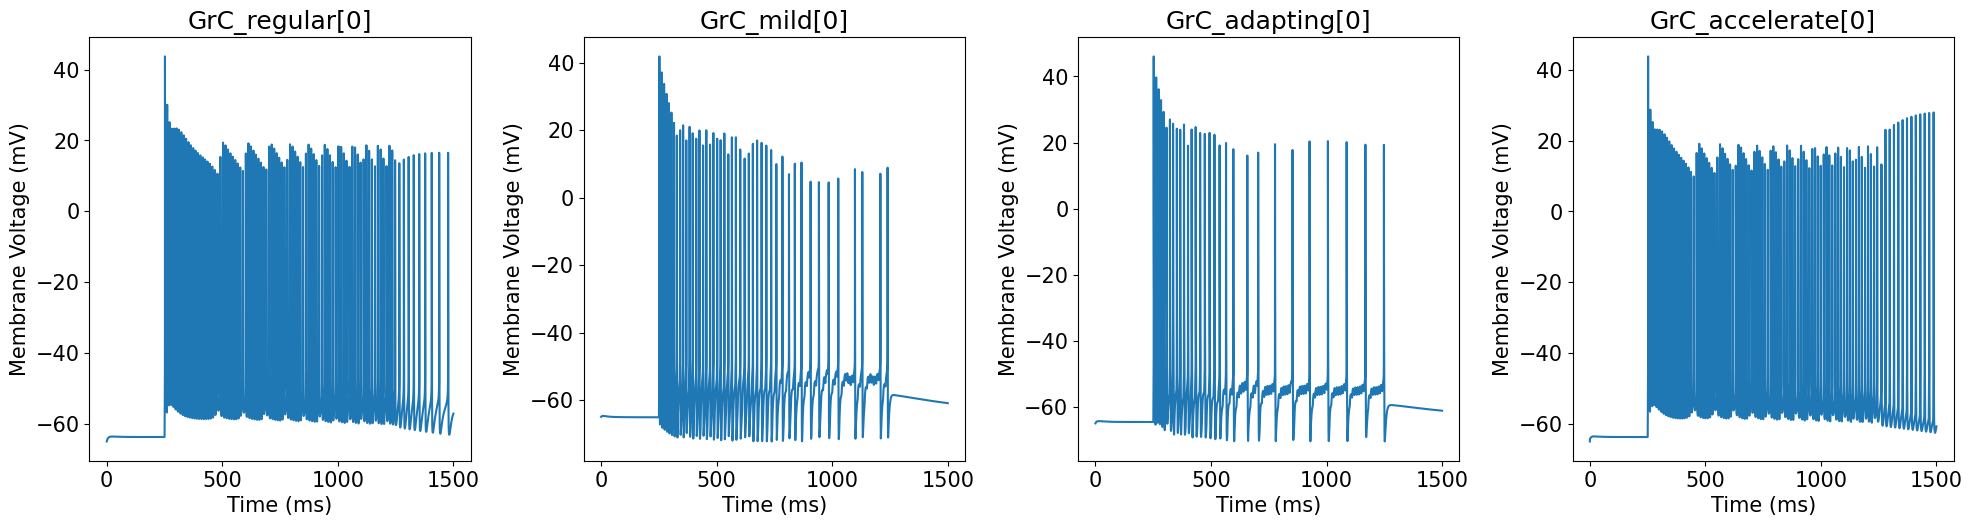

<Figure size 640x480 with 0 Axes>

In [11]:
# plot traces of grc cells
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(1, 2, figsize = (20, 20))

for j, grc_cell in enumerate(grc_cells):                
    plt.subplot(len(grc_cells), 4, j + 1)
    plt.plot(t, grc_cell.vm, label=str(grc_cell))
    plt.title(f"{grc_cell}")
    plt.xlabel("Time (ms)")
    plt.ylabel("Membrane Voltage (mV)")

    data = np.array(grc_cell.vm)
    data[data>50] = 50
    grc_vm.append(data)
    widths, peaks = get_halfwidth(data, threshold=0, distance=0.0001)

    grc_fr_array.append(len(grc_cell.spike_time_vec))
    max_grc_v_array.append(peaks)
    min_grc_v_array.append(np.min(data))
    grc_halfwidth_array.append(widths)

plt.tight_layout()
plt.show()
plt.savefig('mid_rp_100Hz_grc_cells.svg', dpi = 300, facecolor='white', transparent=True)

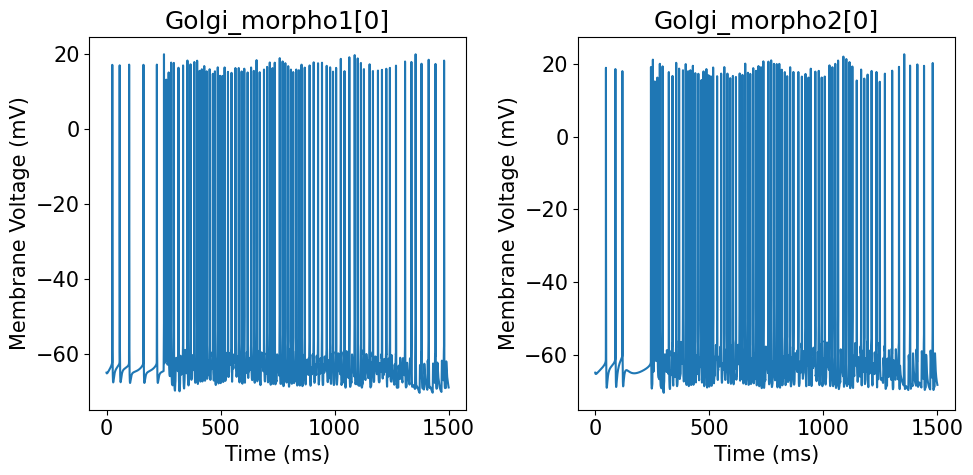

<Figure size 640x480 with 0 Axes>

In [12]:
# plot traces of golgi cells
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

for j, golgi_cell in enumerate(golgi_cells):

    plt.subplot(len(golgi_cells)//2, 2, j + 1)
    plt.plot(t, golgi_cell.vm, label=str(golgi_cell))
    plt.title(f"{golgi_cell}")
    plt.xlabel("Time (ms)")
    plt.ylabel("Membrane Voltage (mV)")

    data = np.array(golgi_cell.vm)
    data[data>50] = 50
    golgi_vm.append(data)
    widths, peaks = get_halfwidth(data, threshold=0, distance=0.0001)

    golgi_fr_array.append(len(golgi_cell.spike_time_vec)) # store number of times fired
    max_golgi_v_array.append(peaks) # store max amp
    min_golgi_v_array.append(np.min(data)) # store min amp
    golgi_halfwidth_array.append(widths)

plt.tight_layout()
plt.show()
plt.savefig('mid_rp_100Hz_golgi_cells.svg', dpi = 300, facecolor='white', transparent=True)

In [16]:
np.mean(golgi_halfwidth_array)

0.4126575759703492

In [13]:
golgi_halfwidth_array = np.concatenate(golgi_halfwidth_array)
grc_halfwidth_array = np.concatenate(grc_halfwidth_array)
max_golgi_v_array = np.concatenate(max_golgi_v_array)
max_grc_v_array = np.concatenate(max_grc_v_array)

sim_dict = {'data': {'time_array': t,
                     'golgi_vm_array': golgi_vm,
                     'grc_vm_array': grc_vm,
                     'golgi_fr_array': golgi_fr_array,
                     'grc_fr_array': grc_fr_array,      
                     'golgi_halfwidth_array': golgi_halfwidth_array,
                     'grc_halfwidth_array': grc_halfwidth_array,
                     'max_golgi_v_array': max_golgi_v_array,
                     'min_golgi_v_array': min_golgi_v_array,
                     'max_grc_v_array': max_grc_v_array,
                     'min_grc_v_array': min_grc_v_array},
            'metadata': {'grc_cells': len(grc_cells), 
                         'golgi_cells': len(golgi_cells), 
                         'ascending_axons': len(ascending_axons),
                         'parallel_fibers': len(parallel_fibers),
                         'freq': freq,
                         'delay': delay,
                         'duration': duration},
            'parameters': {'time_steps': h.dt,
                           'temp': h.celsius,
                           'v_init': h.v_init,
                           'duration': h.tstop}}

if golgi_input_resis_array != []:
    sim_dict['data']['golgi_input_resis_array'] = golgi_input_resis_array
    sim_dict['data']['grc_input_resis_array'] = grc_input_resis_array

In [14]:
# export data using hdf5 utils function to import into generate figures
file_path = 'data/sim_history.hdf5'
model_name = 'mid_rp_testing_100Hz'
export_data(sim_dict, model_name, file_path) 

<HDF5 group "/mid_rp_testing_100Hz" (0 members)>
<HDF5 dataset "time_array": shape (60001,), type "<f8">
<HDF5 dataset "golgi_vm_array": shape (2, 60001), type "<f8">
<HDF5 dataset "grc_vm_array": shape (4, 60001), type "<f8">
<HDF5 dataset "golgi_fr_array": shape (2,), type "<i8">
<HDF5 dataset "grc_fr_array": shape (4,), type "<i8">
<HDF5 dataset "golgi_halfwidth_array": shape (167,), type "<f8">
<HDF5 dataset "grc_halfwidth_array": shape (273,), type "<f8">
<HDF5 dataset "max_golgi_v_array": shape (167,), type "<f8">
<HDF5 dataset "min_golgi_v_array": shape (2,), type "<f8">
<HDF5 dataset "max_grc_v_array": shape (273,), type "<f8">
<HDF5 dataset "min_grc_v_array": shape (4,), type "<f8">
<HDF5 group "/mid_rp_testing_100Hz" (1 members)>
<HDF5 dataset "grc_cells": shape (), type "<i8">
<HDF5 dataset "golgi_cells": shape (), type "<i8">
<HDF5 dataset "ascending_axons": shape (), type "<i8">
<HDF5 dataset "parallel_fibers": shape (), type "<i8">
<HDF5 dataset "freq": shape (), type "<i